In [5]:
# ✅ Further Enhanced: Long-Term RL Strategy with Deep Evolution Strategy Agent (TensorFlow 2 Style Format)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.001
skip = 1

# Utility Functions

def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

# Model & Evolution

class DeepEvolutionStrategy:
    def __init__(self, weights, reward_function, population_size=15, sigma=0.1, learning_rate=0.03):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        return [w + self.sigma * p for w, p in zip(weights, population)]

    def train(self, epoch=100, print_every=1):
        for i in range(epoch):
            population = [[np.random.randn(*w.shape) for w in self.weights] for _ in range(self.population_size)]
            rewards = np.array([
                self.reward_function(self._get_weight_from_population(self.weights, pop))
                for pop in population
            ])
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
            for j in range(len(self.weights)):
                A = np.array([p[j] for p in population])
                self.weights[j] += self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T

class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(input_size, layer_size)  # match dimensions with input for broadcasting
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

class DESAgent:
    def __init__(self, model, max_buy, max_sell, trend):
        self.model = model
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.trend = trend
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.get_weights(), self.get_reward, population_size=15, sigma=0.1, learning_rate=0.03
        )

    def act(self, state):
        decision, buy = self.model.predict(state)
        return np.argmax(decision[0]), max(int(buy[0]), 0)

    def get_reward(self, weights):
        self.model.set_weights(weights)
        state = get_state(self.trend, 0, window_size + 1)
        inventory = []
        quantity = 0
        money = self.initial_money
        for t in range(0, len(self.trend) - 1, skip):
            action, buy = self.act(state)
            next_state = get_state(self.trend, t + 1, window_size + 1)
            price = self.trend[t]
            if action == 1 and money >= price:
                buy_units = min(max(buy, 1), self.max_buy)
                money -= buy_units * price
                inventory.extend([price] * buy_units)
                quantity += buy_units
            elif action == 2 and quantity > 0:
                sell_units = min(quantity, self.max_sell)
                money += sell_units * price
                quantity -= sell_units
                inventory = inventory[sell_units:]
            state = next_state
        return ((money - self.initial_money) / self.initial_money) * 100

    def train(self, iterations=100, checkpoint=10):
        self.es.train(epoch=iterations, print_every=checkpoint)

    def trade(self):
        state = get_state(self.trend, 0, window_size + 1)
        inventory = []
        quantity = 0
        money = self.initial_money
        starting_money = money
        states_buy = []
        states_sell = []

        for t in range(0, len(self.trend) - 1, skip):
            action, buy = self.act(state)
            next_state = get_state(self.trend, t + 1, window_size + 1)
            price = self.trend[t]
            if action == 1 and money >= price:
                buy_units = min(max(buy, 1), self.max_buy)
                money -= buy_units * price
                inventory.extend([price] * buy_units)
                quantity += buy_units
                states_buy.append(t)
            elif action == 2 and quantity > 0:
                sell_units = min(quantity, self.max_sell)
                money += sell_units * price
                quantity -= sell_units
                inventory = inventory[sell_units:]
                states_sell.append(t)
            state = next_state

        final_value = money + quantity * self.trend[-1]
        roi = (final_value - starting_money) / starting_money * 100
        return states_buy, states_sell, final_value, roi

# Run Strategy
portfolio_results = {}
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}


for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    model = Model(window_size, 500, 3)
    agent = DESAgent(model, max_buy=5, max_sell=5, trend=close)
    agent.train(iterations=100, checkpoint=10)
    states_buy, states_sell, final_value, roi = agent.trade()

    portfolio_results[ticker] = {"ROI": roi, "Final Value": final_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${final_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()



Processing U11.SI...


/tmp/ipykernel_21980/907933126.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


KeyboardInterrupt: 


Processing Q0F.SI...


/tmp/ipykernel_316448/1021319210.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


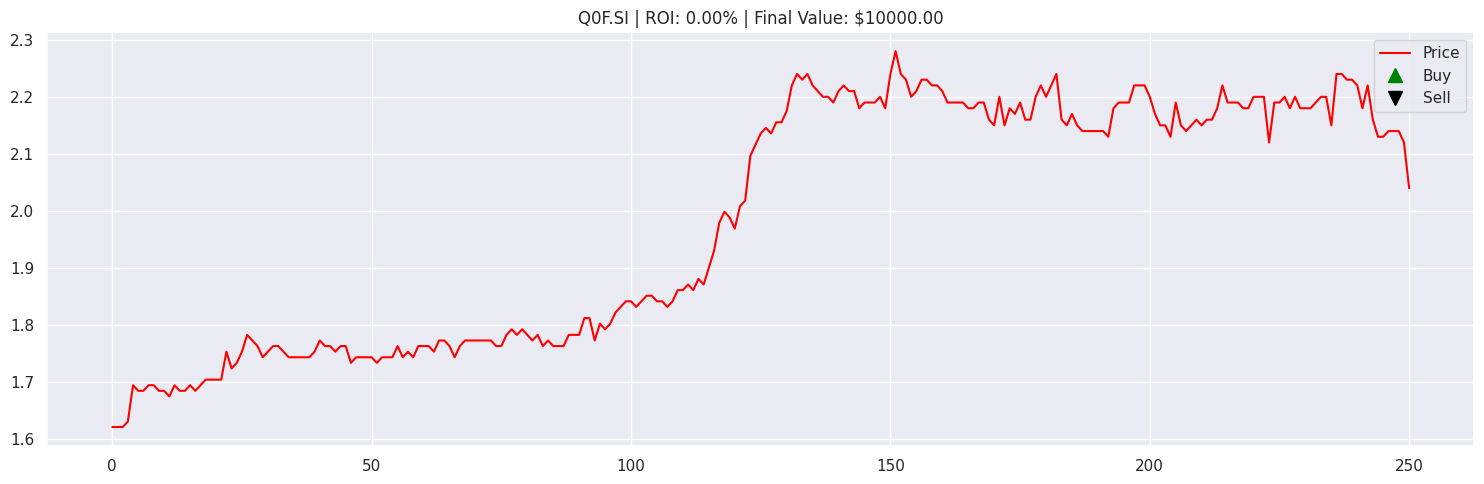


Processing G13.SI...


/tmp/ipykernel_316448/1021319210.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


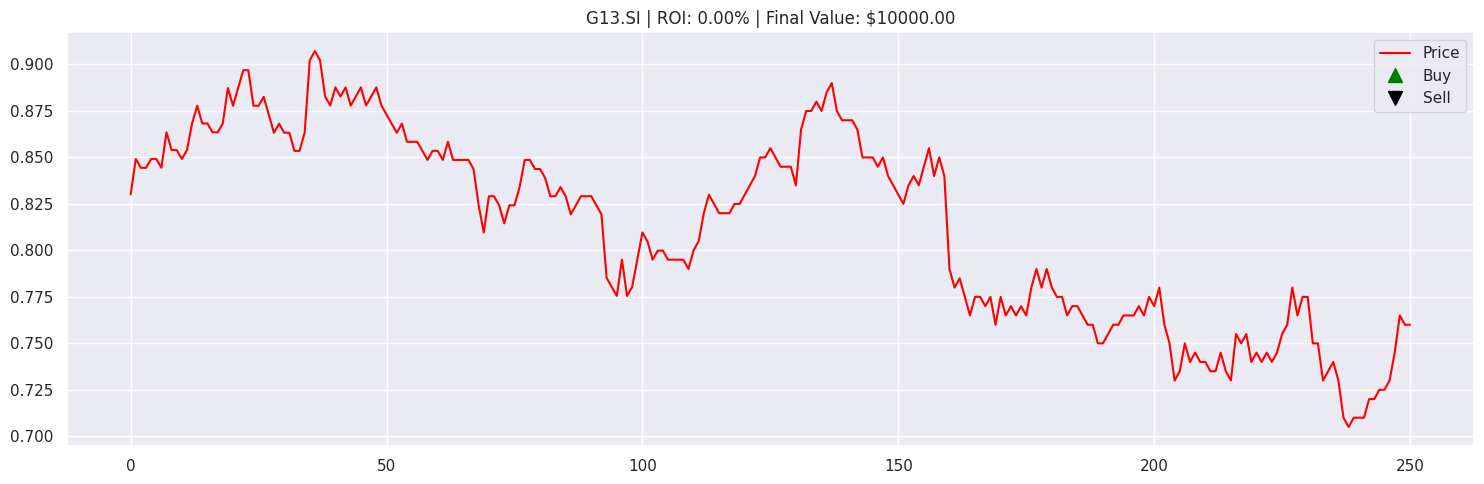


Processing C6L.SI...


/tmp/ipykernel_316448/1021319210.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


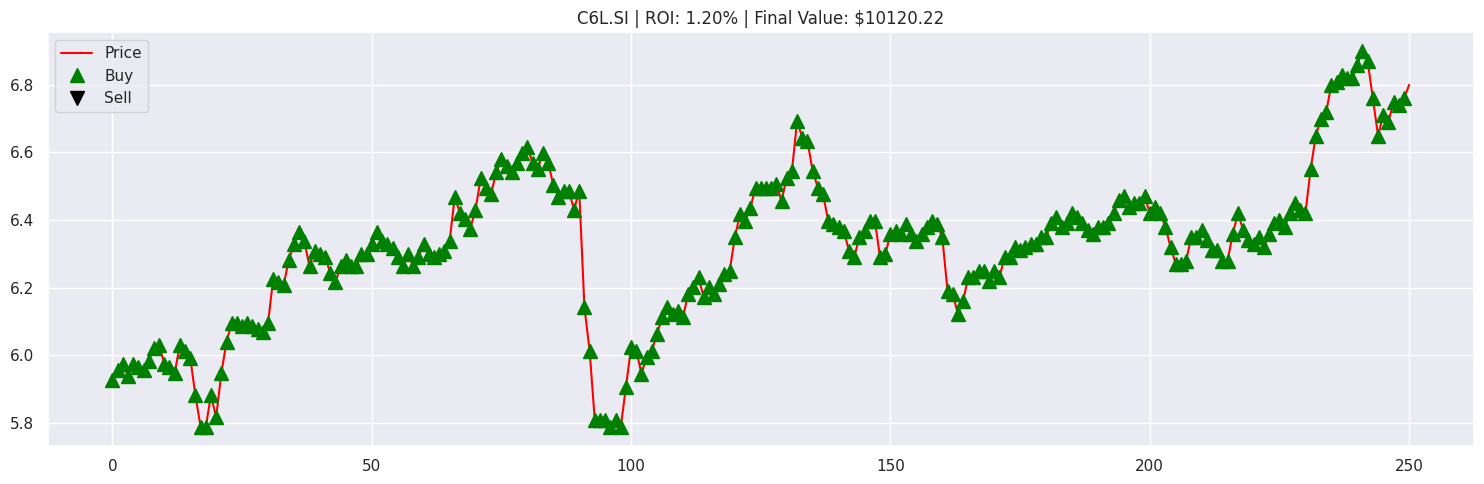


Processing C38U.SI...


/tmp/ipykernel_316448/1021319210.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


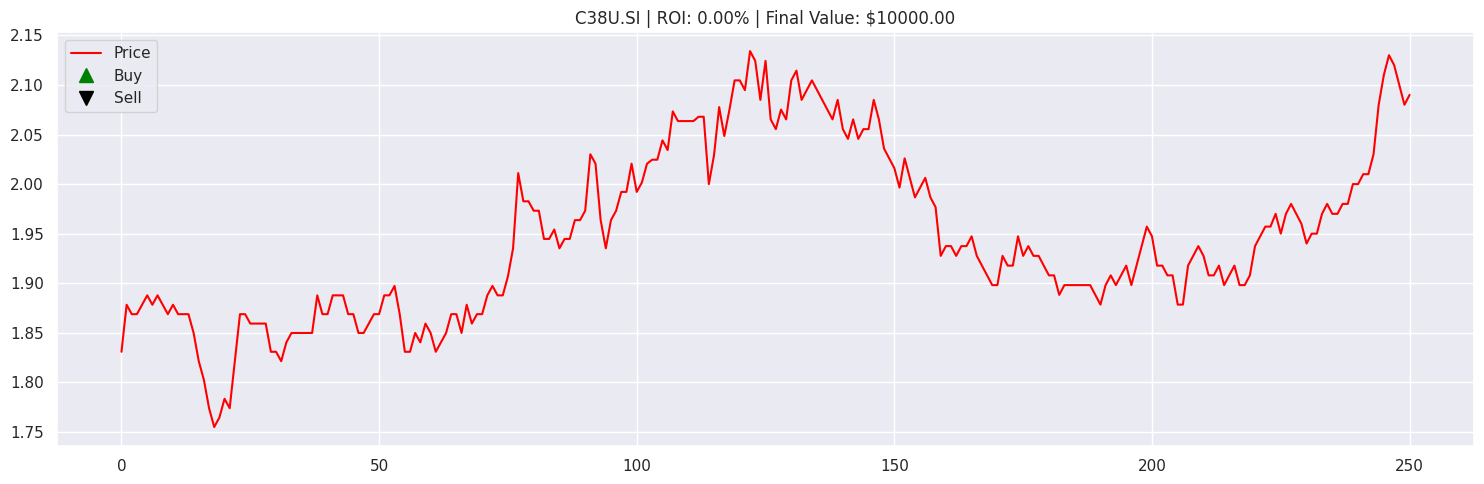


Processing 9CI.SI...


/tmp/ipykernel_316448/1021319210.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


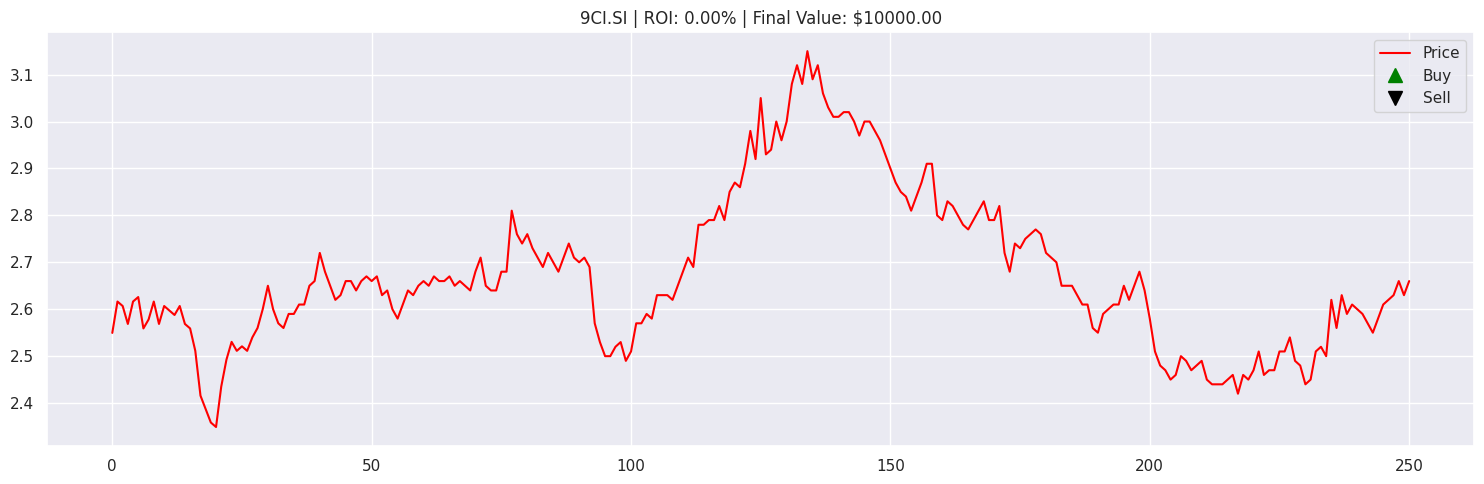


Processing C07.SI...


/tmp/ipykernel_316448/1021319210.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.argmax(decision[0]), max(int(buy[0]), 0)


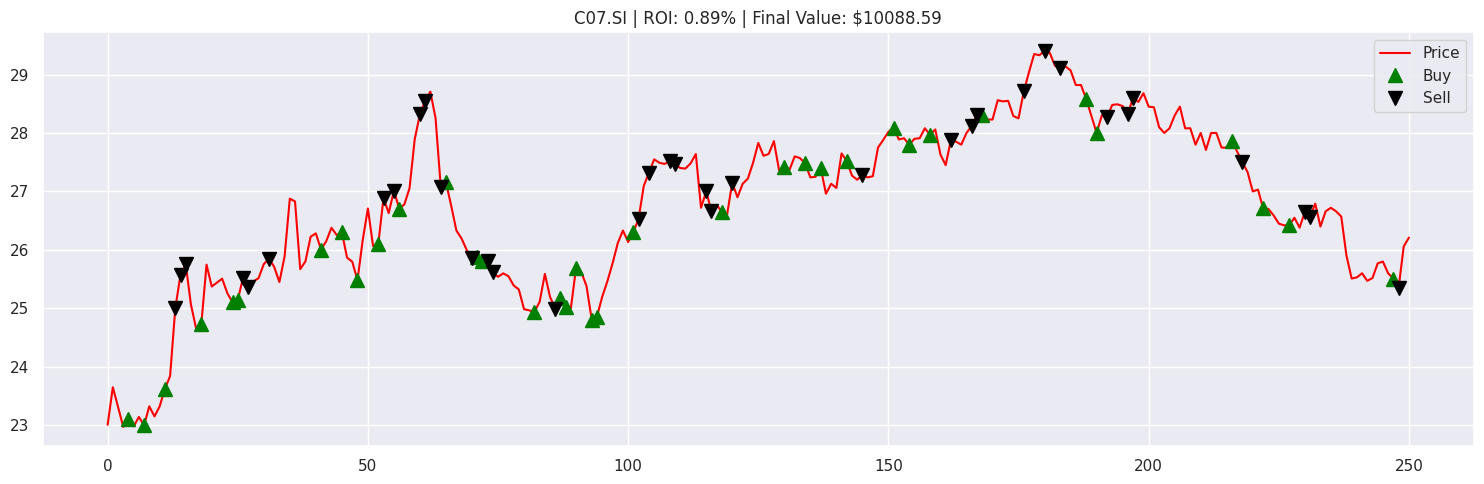


Portfolio Summary:
              ROI   Final Value
Q0F.SI   0.000000  10000.000000
G13.SI   0.000000  10000.000000
C6L.SI   1.202216  10120.221577
C38U.SI  0.000000  10000.000000
9CI.SI   0.000000  10000.000000
C07.SI   0.885939  10088.593857


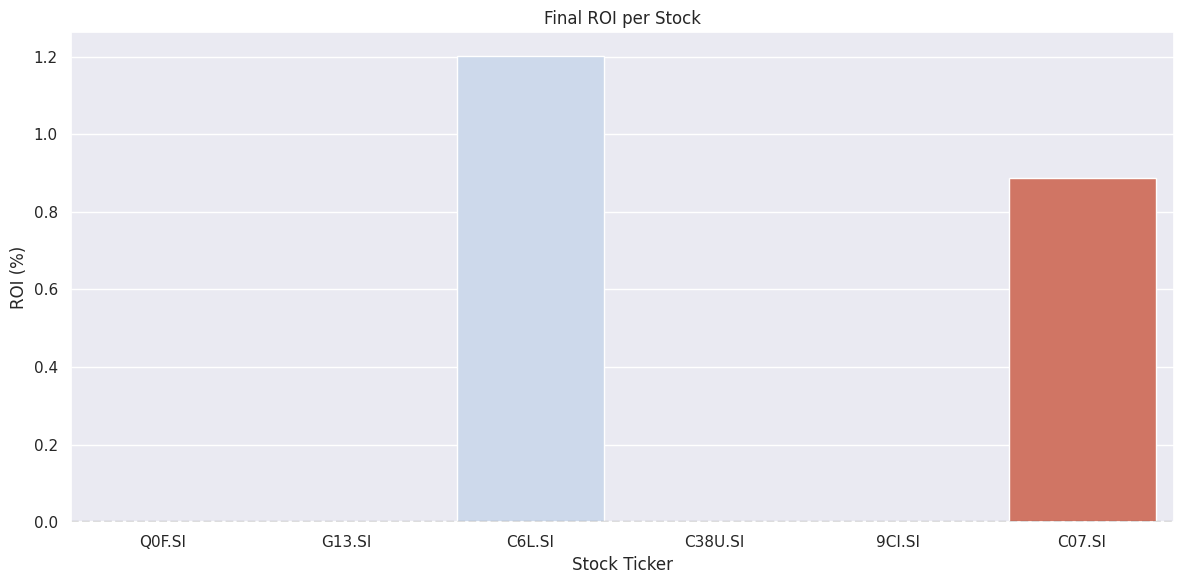

In [7]:
# ✅ Further Enhanced: Long-Term RL Strategy with Deep Evolution Strategy Agent (TensorFlow 2 Style Format)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.001
skip = 1

# Utility Functions

def get_state(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = [block[i + 1] - block[i] for i in range(n - 1)]
    return np.array([res])

# Model & Evolution

class DeepEvolutionStrategy:
    def __init__(self, weights, reward_function, population_size=50, sigma=0.05, learning_rate=0.01):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        return [w + self.sigma * p for w, p in zip(weights, population)]

    def train(self, epoch=100, print_every=1):
        for i in range(epoch):
            population = [[np.random.randn(*w.shape) for w in self.weights] for _ in range(self.population_size)]
            rewards = np.array([
                self.reward_function(self._get_weight_from_population(self.weights, pop))
                for pop in population
            ])
            rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
            for j in range(len(self.weights)):
                A = np.array([p[j] for p in population])
                self.weights[j] += self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T

class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(input_size, layer_size)
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

class DESAgent:
    def __init__(self, model, max_buy, max_sell, trend):
        self.model = model
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.trend = trend
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.get_weights(), self.get_reward, population_size=50, sigma=0.05, learning_rate=0.01
        )

    def act(self, state):
        decision, buy = self.model.predict(state)
        return np.argmax(decision[0]), max(int(buy[0]), 0)

    def get_reward(self, weights):
        self.model.set_weights(weights)
        state = get_state(self.trend, 0, window_size + 1)
        inventory = []
        quantity = 0
        money = self.initial_money
        for t in range(0, len(self.trend) - 1, skip):
            action, buy = self.act(state)
            next_state = get_state(self.trend, t + 1, window_size + 1)
            price = self.trend[t]
            if action == 1 and money >= price:
                buy_units = min(max(buy, 1), self.max_buy)
                money -= buy_units * price
                inventory.extend([price] * buy_units)
                quantity += buy_units
            elif action == 2 and quantity > 0:
                sell_units = min(quantity, self.max_sell)
                money += sell_units * price
                quantity -= sell_units
                inventory = inventory[sell_units:]
            state = next_state
        return ((money - self.initial_money) / self.initial_money) * 100

    def train(self, iterations=150, checkpoint=10):
        self.es.train(epoch=iterations, print_every=checkpoint)

    def trade(self):
        state = get_state(self.trend, 0, window_size + 1)
        inventory = []
        quantity = 0
        money = self.initial_money
        starting_money = money
        states_buy = []
        states_sell = []

        for t in range(0, len(self.trend) - 1, skip):
            action, buy = self.act(state)
            next_state = get_state(self.trend, t + 1, window_size + 1)
            price = self.trend[t]
            if action == 1 and money >= price:
                buy_units = min(max(buy, 1), self.max_buy)
                money -= buy_units * price
                inventory.extend([price] * buy_units)
                quantity += buy_units
                states_buy.append(t)
            elif action == 2 and quantity > 0:
                sell_units = min(quantity, self.max_sell)
                money += sell_units * price
                quantity -= sell_units
                inventory = inventory[sell_units:]
                states_sell.append(t)
            state = next_state

        final_value = money + quantity * self.trend[-1]
        roi = (final_value - starting_money) / starting_money * 100
        return states_buy, states_sell, final_value, roi

# Run Strategy
portfolio_results = {}
tickers = {"Q0F.SI", "C6L.SI", "C38U.SI", "9CI.SI", "C07.SI", "G13.SI"}

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    model = Model(window_size, 128, 3)
    agent = DESAgent(model, max_buy=3, max_sell=3, trend=close)
    agent.train(iterations=150, checkpoint=10)
    states_buy, states_sell, final_value, roi = agent.trade()

    portfolio_results[ticker] = {"ROI": roi, "Final Value": final_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${final_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()


Processing U11.SI...
U11.SI: Final Portfolio = 30.113809329322976, Shares Held = 823.0, Last Price = 38.2599983215332


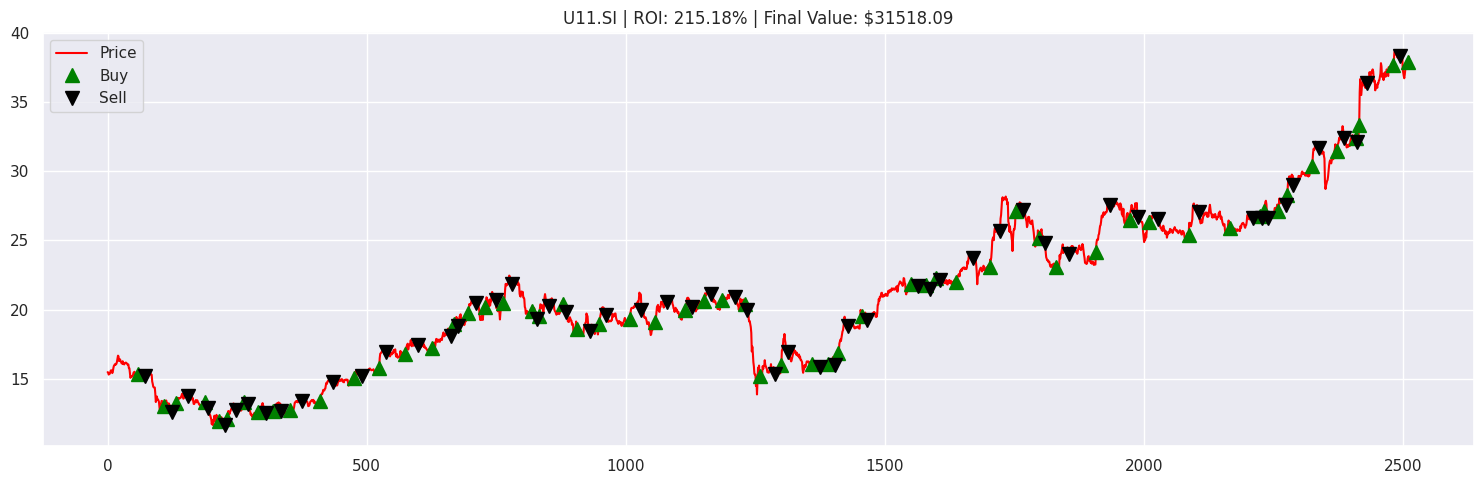


Processing C38U.SI...
C38U.SI: Final Portfolio = 1.0201097980207123, Shares Held = 9159.0, Last Price = 2.0999999046325684


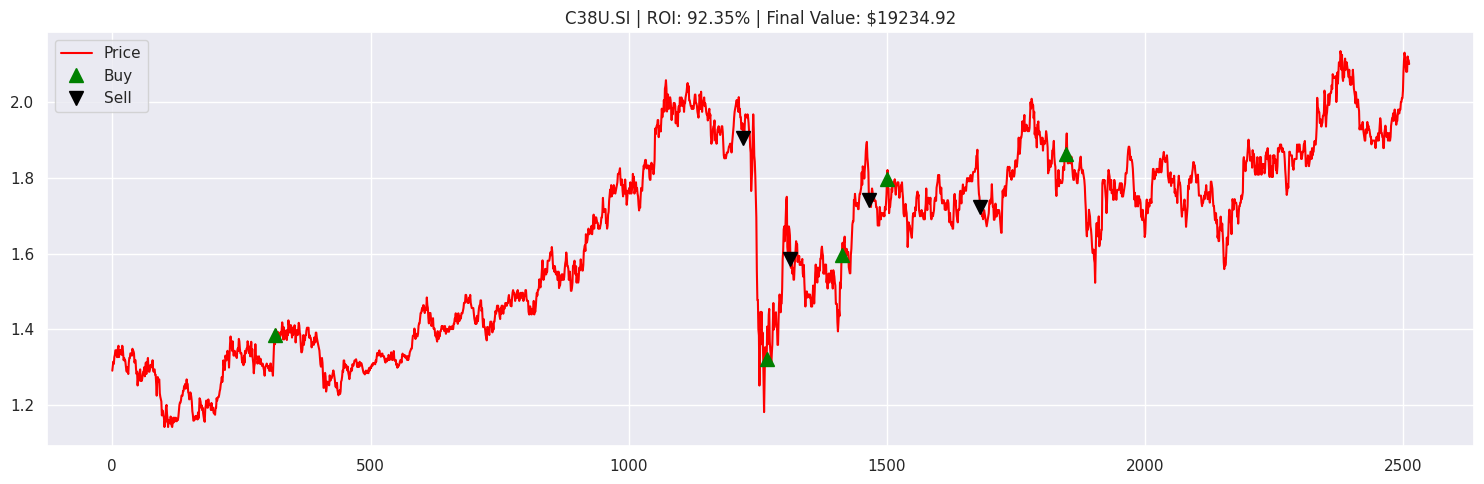


Processing Q0F.SI...
Q0F.SI: Final Portfolio = 14537.980157343156, Shares Held = 0, Last Price = 2.0249998569488525


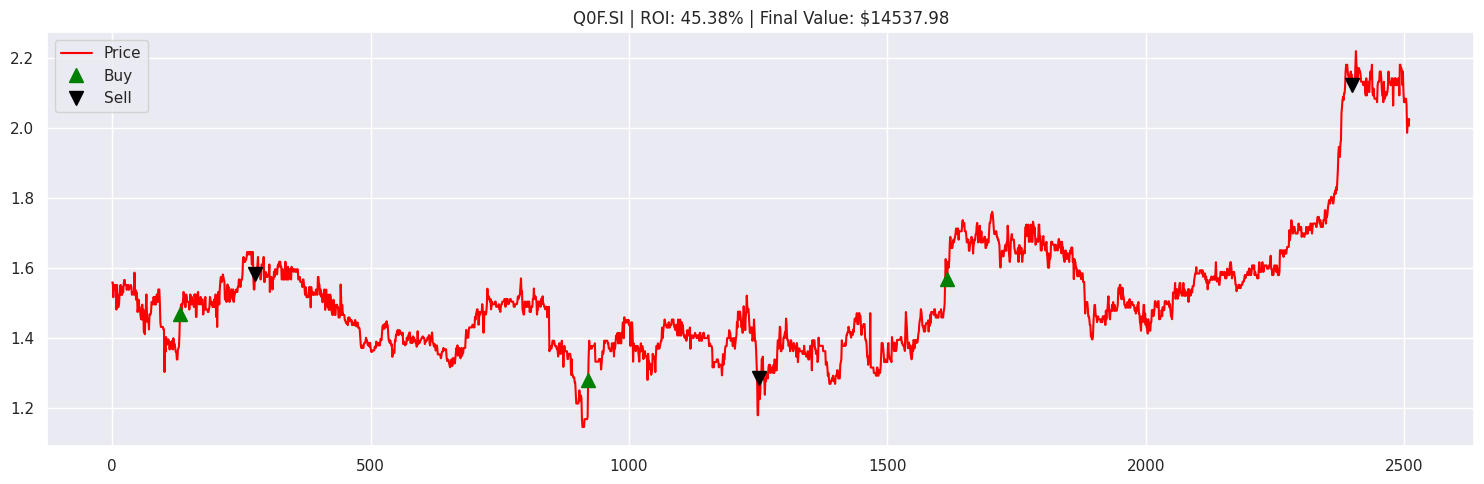


Processing S68.SI...
S68.SI: Final Portfolio = 6.637443343413906, Shares Held = 1501.0, Last Price = 13.25


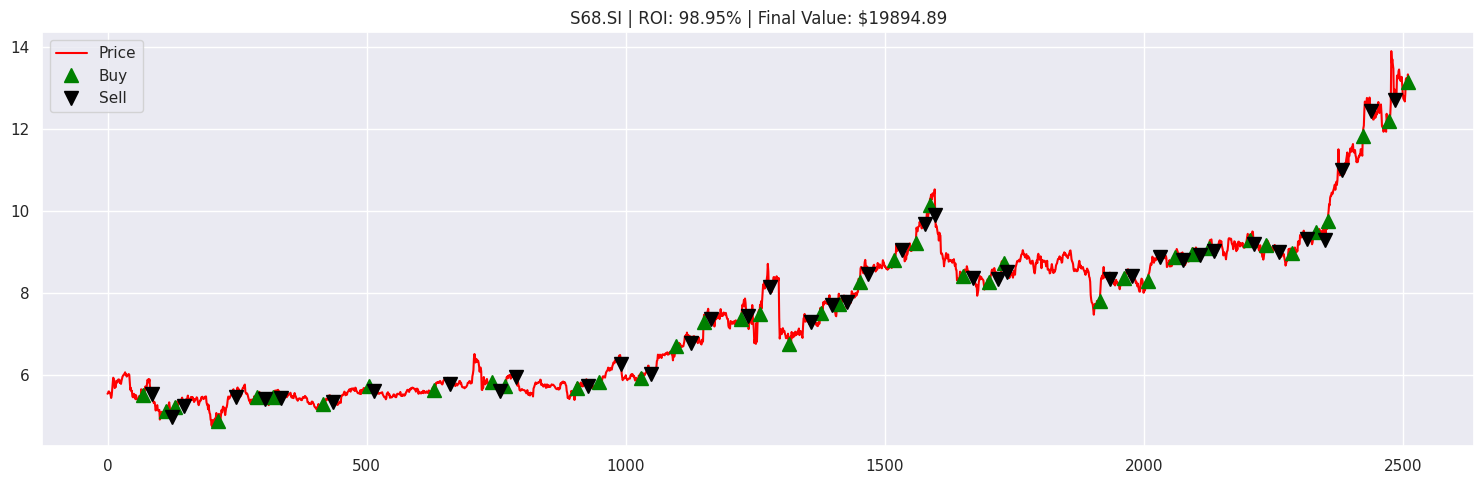


Processing S63.SI...
S63.SI: Final Portfolio = 0.7279492364868929, Shares Held = 2736.0, Last Price = 6.730000019073486


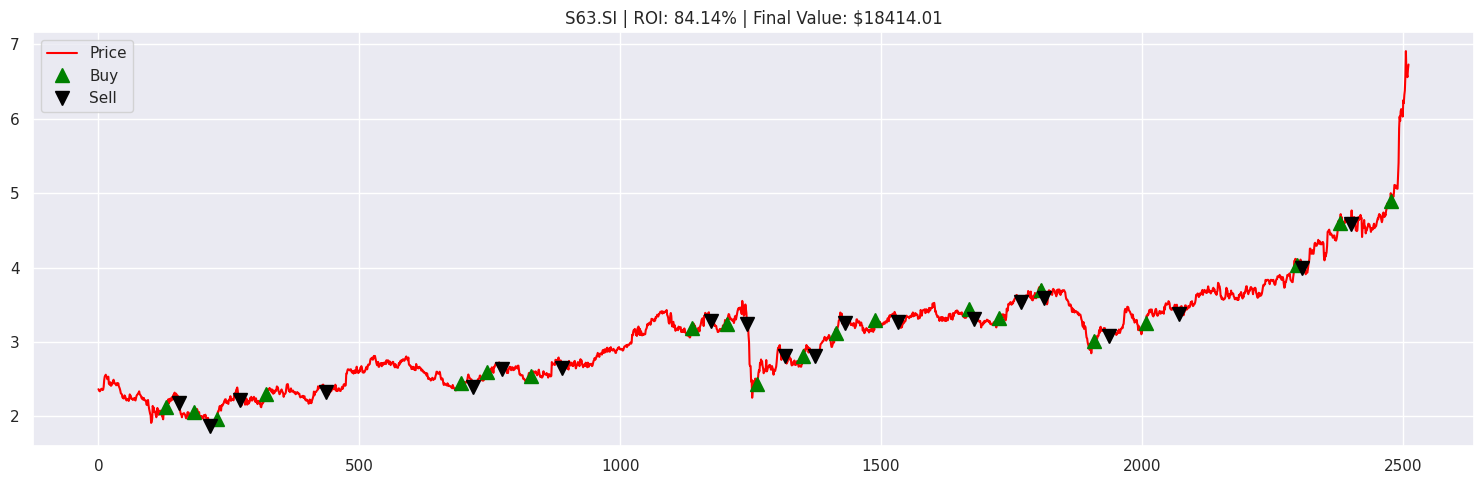


Processing AJBU.SI...
AJBU.SI: Final Portfolio = 11935.51419780776, Shares Held = 0, Last Price = 2.190000057220459


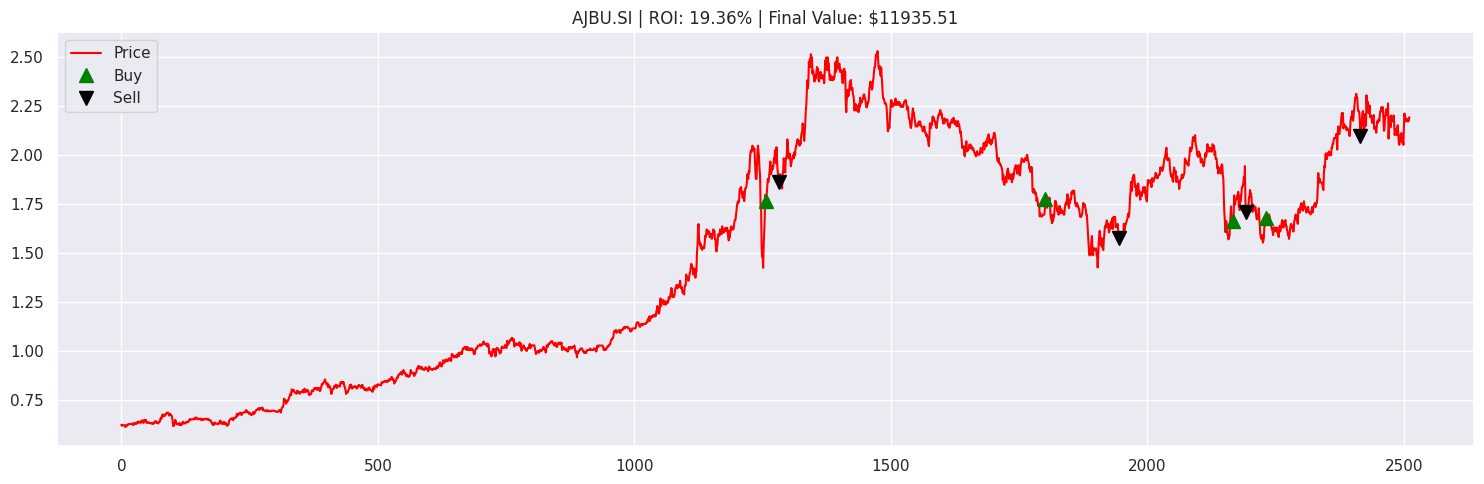


Portfolio Summary:
                ROI   Final Value
U11.SI   215.180924  31518.092428
C38U.SI   92.349192  19234.919236
Q0F.SI    45.379802  14537.980157
S68.SI    98.948874  19894.887443
S63.SI    84.140080  18414.008001
AJBU.SI   19.355142  11935.514198


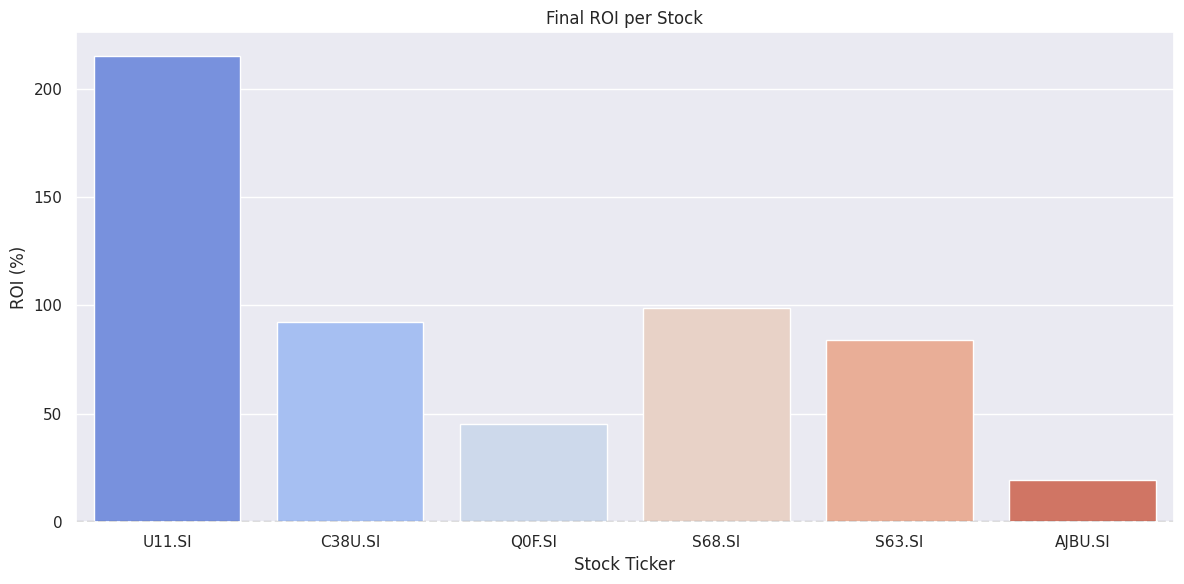

In [4]:
# ✅ Optimized: Long-Term RL Trading Strategy with Adaptive MACD/RSI/RMA and Smarter Buy-Sell Filtering for Higher ROI

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.00125
alpha_threshold = 0.01
beta_threshold = -0.01
risk_rsi_low = 30
risk_rsi_high = 70
min_trade_profit = 0.005

# Indicator Calculations
def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)

def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)

def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values

def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])

# Agent Class
class DESAgent:
    def __init__(self, window_size):
        self.window_size = window_size

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

# Execution
portfolio_results = {}
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}


for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    df = df.dropna(subset=["Close"])  # Drop any NaNs in Close
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    agent = DESAgent(window_size)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50

        action = 0
        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        if macd_diff > alpha_threshold and rsi_val < risk_rsi_high and expected_profit > min_trade_profit * current_price:
            action = 1
        elif macd_diff < beta_threshold and rsi_val > risk_rsi_low and shares_held > 0:
            action = 2

        if action == 1 and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)

        elif action == 2 and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)
    print(f"{ticker}: Final Portfolio = {portfolio}, Shares Held = {shares_held}, Last Price = {close[-1]}")

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv('results_des.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()